# Predator Prey Model with MLDA

To DO! 

* Add check to Jacobian to ensure $P_f$ and $Q_f$ are positive, and eigenvalues of Jacobian are positive, real at this fixed point

* Add plotting facility for solutions.

## Model

We consider a classical ecology model which describes the interaction in populations of Predators ($Q$) and Prey ($P$) over time, described by the system of nonlinear ordinary differential equations

\begin{equation}
\frac{dP}{dt} = rP\left(1 - \frac{P}{k}\right) - s\frac{PQ}{a + P}\quad \mbox{and} \quad \frac{dQ}{dt} = v \frac{PQ}{a + P} - uQ, \qquad \mbox{for all} \quad t > 0.
\end{equation}


The model outputs are fully described the parameters 

$$\theta = [P_0, Q_0, r, K, s, a, u, v].$$

The parameters include the initial populations of prey and predators at time $t=0$ denoted $P_0$ and $Q_0$ respectively. The other are ecological parameters: $r$ the prey growth rate, $k$ the prey capacity, $s$ the predation rate, $a$ the predation hunger, $u$ the predator loss and $v$ the predator growth rates. For further details see [1].

For this example we wish to infer the distribution of $\theta$ (i.e calibrate our model), given six noisy observations of predator numbers at discrete time intervals, i.e. $P(t^\star)$ for $t^\star$ equally spaced between 0 and 50 days. In this example the observations are generated by solving the system of equations with the "true" parameters

$$
\theta^\star = [50, 5, 0.6, 100, 1.2, 25, 0.5, 0.3]
$$

and perturbing the population values $P(t^\star)$ with independent Gaussian noise $\xi \sim \mathcal N(0, 5)$. Our aim is to infer the distribution of $Q(t)$ over the same period.

The system of ordinary equations are a set of nonlinear first order differential equations. The solutions can be approximated by a suitable numerical integration. In this case we use the simple explicit Euler time-stepper, with a fixed time step (level dependent) $\Delta t_\ell$.

The MCMC chain is run on a set of parameters $\tilde \theta$, which is $\theta$ rescaled by the "true" parameters. The prior for this problem is uniform over the intersection of a hypercube in parameter space, $\pi(\tilde \theta) \sim \mathcal U[0.5,1.5]^8$.

Fixed points of the systems is a population state in the system, $(P_f,Q_f)$ for which the $\frac{dP}{dt} = \frac{dQ}{dt} = 0$. For this population model it follows that

\begin{equation}
P_f = \frac{ua}{v - a} \quad \mbox{and} \quad Q_f = r\left(a + P_f\right)\left(\frac{P_f}{k} - 1\right).
\end{equation}

The stability at the first point is determined by the eigenvalues of the Jacobian at $(P_f,Q_f)$, given by

\begin{equation}
\mathcal J (P_f, Q_f) = 
\begin{bmatrix}
r\left(1 - \frac{2P}{k}\right) - \frac{s Q}{a + P}\left(1 - \frac{P}{(a + P)}\right) & -\frac{sP}{a + P} \\
\frac{v Q}{a + P} - \frac{v P Q}{(a + P)^2} & \frac{v P}{a + P} - u
\end{bmatrix}
\end{equation}



### References

[1] Rockwood, Introduction to Population Ecology, Wiley-Blackwell, 1 ed., 2006.

[2]S. Strogatz, Nonlinear Dynamics and Chaos, Westview Press, 2001.

In [60]:
import numpy as np

from numpy import linalg as LA

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt

import time

import pymc3 as pm

import theano.tensor as tt

In [61]:
class PredatorPrey:
    
    def __init__(self, dt, numDataPoints):
    
        self.dt = dt
        
        self.T = 100
        
        self.numDataPoints = numDataPoints
        
        self.numData = 6
        
        self.t_star = np.linspace(0.0, self.T, self.numData + 1)
        
        self.t_eval = self.t_star[1:self.numDataPoints+1]
        
        self.sigf = 0.1
        
        self.true_theta = [50, 5, 0.6, 100, 1.2, 25, 0.5, 0.3]
    
    def pp(self,t, y, r, k, s, a,u,v):
            P, Q = y
            return [r*P*(1 - P/k) - s * P * Q/(a + P), u * P * Q/ (a + P) - v * Q]
        
    
  

    def setData(self, data):
        self.Data = data
        
    
    def simulate(self, theta, forPlotting = False):
        
        rescaled_theta = [a * b for a,b in zip(self.true_theta,theta)]
     
        P0, Q0, r, k, s, a, u, v = rescaled_theta
             
        if(forPlotting):
            sol = solve_ivp(self.pp, [0, self.T], [P0, Q0], max_step = self.dt, args=(r, k, s, a, u, v))
            return sol
        else:
            sol = solve_ivp(self.pp, [0, self.t_eval[-1]], [P0, Q0], t_eval = self.t_eval, max_step = self.dt, args=(r, k, s, a, u, v))
            return sol.y[1,:]
    
        

        
    def checkSample(self,theta):
        
        rescaled_theta = [a * b for a,b in zip(self.true_theta,theta)]
     
        P0, Q0, r, k, s, a, u, v = rescaled_theta
        
        
        # Evaluate (Nontrivial) Fix Points
        
        Pf = a * v  / (u - v)
        
        Qf = (r/s)* (a + Pf) * (1. - Pf/k)
        
        assert sum(self.pp(None, [Pf,Qf], r, k, s, a,u,v)) < 1e-6, "(Pf, Qf) appear not to be a fixed point, please check!"
        
        if ((Pf <= 0) or (Qf<=0)):
            return False
        
        J = np.zeros((2,2))
        
        J[0,0] = r - 2 * r * Pf /k - s * Qf / (a + Pf) + s * Pf * Qf / ((a + Pf)**2)
        J[0,1] =  -s * Pf / (a + Pf)
        J[1,0] = v * Qf / (a + Pf) - v * Pf * Qf / ((a + Pf)**2)
        J[1,1] =  v * Pf / (a + Pf) - u
        
        e = LA.eigvals(J)
        

        return True
            
    
    def plot(self, theta, phaseDiagram = False):
        
        # Plotting
        
        sol = self.simulate(theta, True)
        
        if(phaseDiagram == False):
        
            plt.plot(sol.t, sol.y[0,:])
            plt.plot(sol.t, sol.y[1,:])
            plt.xlabel('t')
            plt.xlabel('Population')
            plt.legend(['Prey', 'Predators'], shadow=True)
            
        else:
            plt.plot(sol.y[0,:],sol.y[1,:])
            plt.xlabel('Prey')
            plt.xlabel('Predators')
                
        plt.show()
           
    
    def logDensity(self, theta):
        
        output = self.simulate(theta)
        
        return - (0.5 / self.sigf ** 2) * np.sum((output - self.data) ** 2)

        

In [62]:
numLevels = 2
factor = 3

# Number of draws from the distribution
ndraws = 10000

# Number of burn-in samples
nburn = 5000

# MLDA and Metropolis tuning parameters
tune = True
tune_interval = 100
discard_tuning = True

# Number of independent chains
nchains = 2

# Subsampling rate for MLDA
nsub = 15

# Do blocked/compounds sampling in Metropolis and MLDA 
# Note: This choice applies only to the coarsest level in MLDA 
# (where a Metropolis sampler is used), all other levels use block sampling
blocked = False

# Data generation seed
data_seed = 2020

# Sampling seed
sampling_seed = 12345



In [63]:
dt

[1.0, 0.2]

In [64]:
numData

[4, 6]

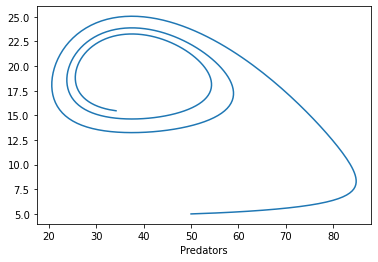

In [65]:


dt = [None] * numLevels
numData = [None] * numLevels
models = [None] * numLevels

param = ['P0', 'Q0', 'r', 'k', 's', 'a', 'u', 'v']

nparam = len(param)

# Setup a Hierarchy of Model with descreasing time step size (dt) and increasing amount of data.
dt[0] = 1.0
numData = [5,6]
for i in range(1,numLevels):
    dt[i] = dt[i-1] / factor
for i in range(numLevels):
    models[i] = PredatorPrey(dt[i],numData[i])


# Generate True Data Using Finest Model
theta_true = [1., 1., 1., 1., 1., 1., 1., 1.]
data = models[-1].simulate(theta_true) # Simulate Solution on finest level
np.random.seed(data_seed) # Set seed for reproducability
data += np.random.normal(0.0, np.sqrt(0.1), size=6) # Add noise to simulated data

for i in range(numLevels): # Set Data for each model
    models[i].data = data[0:numData[i]]

'''
# Estimate Costs for each level
C = [None] * numLevels
for i in range(numLevels):
    start = time.perf_counter()
    for j in range(0,100):       
        models[i].simulate(theta_true)
    C[i] = (time.perf_counter() - start)/100
    
print("Estimated Costs of Dependent Sample Per Level")
print(C)
'''

models[-1].checkSample(theta_true)

models[-1].plot(theta_true,True)

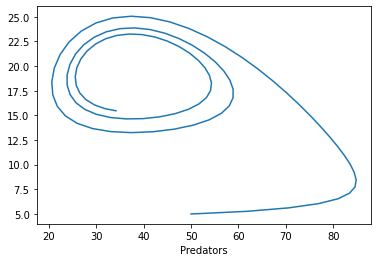

In [66]:
models[-2].checkSample(theta_true)

models[-2].plot(theta_true,True)

In [67]:
#models[-3].data

## Wrap Customised Log Likelihood in Theano Op

 Theano Op that wraps the log-likelihood computation, necessary to pass "black-box" model into pymc3.
 
 For more details see :
 
    https://docs.pymc.io/notebooks/blackbox_external_likelihood.html
    https://docs.pymc.io/Advanced_usage_of_Theano_in_PyMC3.html

In [68]:
class LogLike(tt.Op):
    # Function simply wraps Log-Likelihood calculation in Theano Op
    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, my_model):
        # add inputs as class attributes
        self.my_model = my_model

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta = inputs[0]  # this will contain my variables
        # call the log-likelihood function
        logl = self.my_model.logDensity(theta)
        outputs[0][0] = np.array(logl) # output the log-likelihood
        
# create Theano Ops to wrap likelihoods of all model levels and store them in list
logl = []
for m in models:
    logl.append(LogLike(m))

In [69]:
# Set up models in pymc3 for each level - excluding finest model level
coarse_models = []
for j in range(numLevels - 1):
    
    with pm.Model() as model:
        # uniform priors on parameters
        parameters = []
        
        # Need to write out the parameters with variables
        
        for i in range(nparam):
            parameters.append(pm.Uniform(param[i], lower=0.5, upper=1.5))

        # convert m and c to a tensor vector
        theta = tt.as_tensor_variable(parameters)

        # use a DensityDist (use a lamdba function to "call" the Op)
        ll = logl[j]
        pm.DensityDist('likelihood', lambda v: ll(v), observed={'v': theta})

    coarse_models.append(model)

## Perform Inference Using MLDA and Metropolois


In [70]:
# Set up finest model and perform inference with PyMC3, using the MLDA algorithm
# and passing the coarse_models list created above.
method_names = []
traces = []
runtimes = []
acc = []
ess = []
ess_n = []
performances = []

with pm.Model():
    
    # Uniform priors on parameters
    parameters = []
    for i in range(nparam):
        parameters.append(pm.Uniform(param[i], lower=0.5, upper=1.5))

    # Convert m and c to a tensor vector
    theta = tt.as_tensor_variable(parameters)

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: logl[-1](v), observed={'v': theta})
    
    # Find Map
    
    approxMap = None #pm.find_MAP()

    # Initialise an MLDA step method object, passing the subsampling rate and
    # coarse models list
    # Also initialise a Metropolis step method object
    step_metropolis = pm.Metropolis(tune=tune, tune_interval=tune_interval, blocked=blocked, start = approxMap)
    
    step_mlda = pm.MLDA(subsampling_rates=nsub, coarse_models=coarse_models,
                        tune=tune, tune_interval=tune_interval, base_blocked=blocked, start = approxMap)
    

    # Inference!
    # Metropolis
    #t_start = time.time()
    #method_names.append("Metropolis")
    #traces.append(pm.sample(draws=ndraws, step=step_metropolis,
    #                        chains=nchains, tune=nburn,
    #                        discard_tuned_samples=discard_tuning,
    #                        random_seed=sampling_seed))
    #runtimes.append(time.time() - t_start)
    
    # MLDA
    t_start = time.time()
    method_names.append("MLDA")
    traces.append(pm.sample(draws=ndraws, step=step_mlda,
                            chains=nchains, tune=nburn,
                            discard_tuned_samples=discard_tuning,
                            random_seed=sampling_seed))
    runtimes.append(time.time() - t_start)

/Users/gmingas/projects/pymc3/pymc3/step_methods/metropolis.py:1053: UserWarning: The MLDA implementation in PyMC3 is very young. You should be extra critical about its results.
  
Multiprocess sampling (2 chains in 4 jobs)
MLDA: [v, u, a, s, k, r, Q0, P0]


Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 39014 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [71]:
for i, trace in enumerate(traces):
    acc.append(trace.get_sampler_stats('accepted').mean())
    ess.append(np.array(pm.ess(trace).to_array()))
    ess_n.append(ess[i] / len(trace) / trace.nchains)
    performances.append(ess[i] / runtimes[i])
    print(f'\nSampler {method_names[i]}: {len(trace)} drawn samples in each of '
          f'{trace.nchains} chains.'
          f'\nRuntime: {runtimes[i]} seconds'
          f'\nAcceptance rate: {acc[i]}'
          f'\nESS list: {ess[i]}'
          f'\nNormalised ESS list: {ess_n[i]}'
          f'\nESS/sec: {performances[i]}')


Sampler MLDA: 10000 drawn samples in each of 2 chains.
Runtime: 39014.64213395119 seconds
Acceptance rate: 0.5655
ESS list: [ 8.35368033  7.8539296  16.10677013  3.24088607  3.93491039  3.26745515
  3.14173373  3.05255941]
Normalised ESS list: [0.00041768 0.0003927  0.00080534 0.00016204 0.00019675 0.00016337
 0.00015709 0.00015263]
ESS/sec: [2.14116544e-04 2.01307232e-04 4.12839110e-04 8.30684557e-05
 1.00857273e-04 8.37494584e-05 8.05270422e-05 7.82413791e-05]


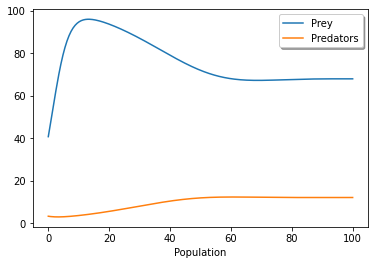

In [72]:
theta_test = np.random.uniform(low=0.5, high=1.5, size=8)

output = models[-1].plot(theta_test)




In [73]:
for i, trace in enumerate(traces):
    print(f"\nSampler {method_names[i]}:\n", pm.stats.summary(trace))


Sampler MLDA:
      mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
P0  0.920  0.250   0.516    1.357      0.093    0.069       7.0     7.0   
Q0  1.219  0.145   1.007    1.483      0.052    0.038       8.0     8.0   
r   1.037  0.045   0.955    1.114      0.011    0.008      16.0    16.0   
k   1.365  0.090   1.190    1.498      0.056    0.045       3.0     3.0   
s   1.369  0.119   1.123    1.500      0.073    0.058       3.0     3.0   
a   1.213  0.116   1.012    1.395      0.070    0.056       3.0     3.0   
u   1.040  0.035   0.973    1.097      0.020    0.016       3.0     3.0   
v   1.100  0.056   1.017    1.187      0.033    0.026       3.0     3.0   

    ess_bulk  ess_tail  r_hat  
P0       8.0     101.0   1.18  
Q0       8.0      57.0   1.20  
r       16.0      48.0   1.07  
k        3.0      17.0   1.68  
s        4.0      21.0   1.47  
a        3.0      16.0   1.67  
u        3.0      16.0   1.71  
v        3.0      28.0   1.74  


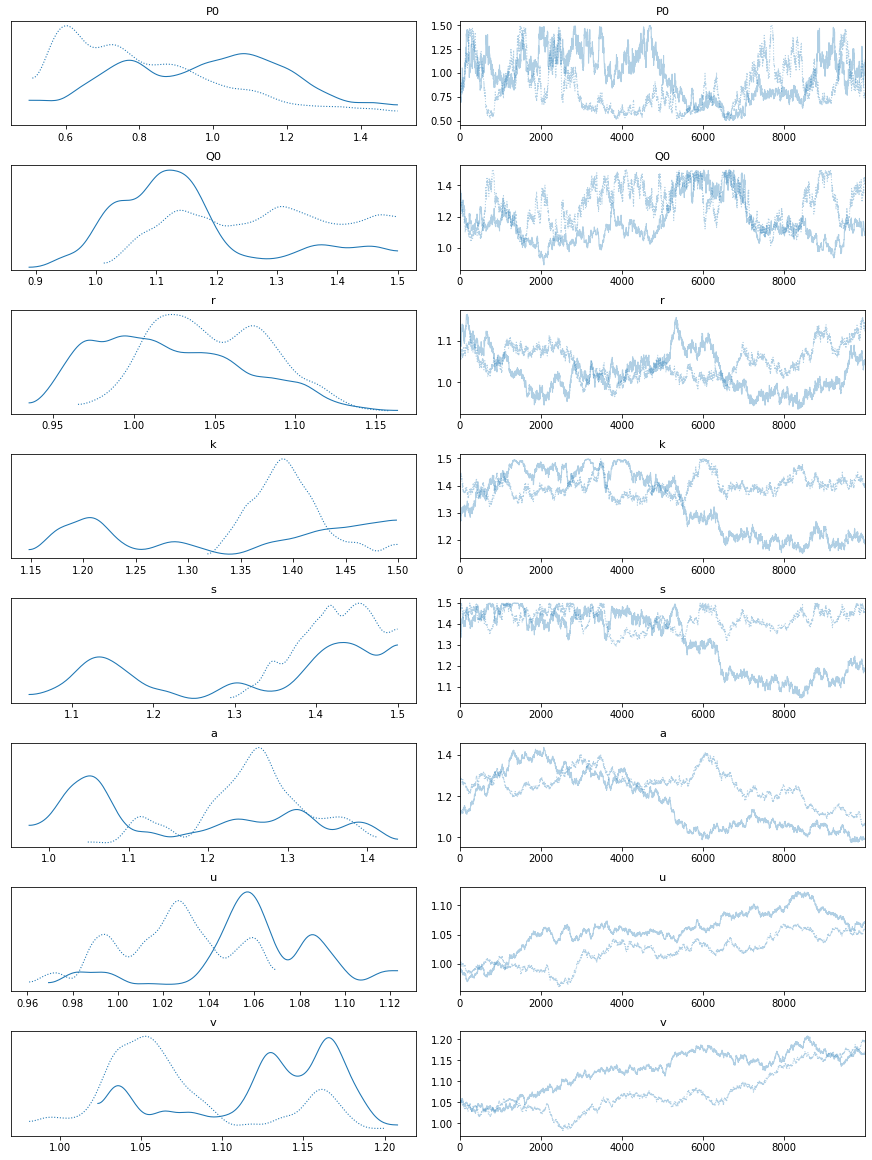

In [74]:
# Print true theta values and pymc3 sampling summary
for i, trace in enumerate(traces):
    pm.plots.traceplot(trace)